# 7.3 Housing Case Study using RFE

In 7.2 we manually removed feature varibles by checking VFI values and P-Values.  This process can be automated using **RFE (Recursive Feature Elimination)**
- Stability depends upond model selected.
 


## Importing and Understanding data

In [1]:
import pandas as pd
import numpy as np

housing = pd.read_csv("Housing.csv")

In [2]:
#First 5 rows
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Data Preparation

Many columns in this dataframe, has categorical data like yes/no, furnished/semi-furnished/unfurnished.
So these values can be converted into numeric values as yes = 1, no = 0 etc.

In [3]:
print(housing['mainroad'].value_counts(), '\n')
print(housing['furnishingstatus'].value_counts())

yes    468
no      77
Name: mainroad, dtype: int64 

semi-furnished    227
unfurnished       178
furnished         140
Name: furnishingstatus, dtype: int64


In [4]:
# https://pbpython.com/categorical-encoding.html

## Approch-1 Find and replace 
# This approach may only work in certain scenarios it is a very useful demonstration of 
# how to convert text values to numeric when there is an “easy” human interpretation of the data. 
# This concept is also useful for more general data cleanup.

housing['mainroad'].replace({'yes':1, 'no':0}, inplace=True)
housing['guestroom'].replace({'yes':1, 'no':0}, inplace=True)
housing['basement'].replace({'yes':1, 'no':0}, inplace=True)
housing['hotwaterheating'].replace({'yes':1, 'no':0}, inplace=True)
housing['airconditioning'].replace({'yes':1, 'no':0}, inplace=True)
housing['prefarea'].replace({'yes':1, 'no':0}, inplace=True)

In [5]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


Now, we have converted yes,no values into 1,0  respectively. Remaining column is furnishingstatus. It has 3 values as:
semi-furnished, unfurnished, furnished. We can replace these values with 1,0,2 respectively. But, this has disadvantage as numeric values can be "misinterpreted" by the algorithms. So there is also another technique called as **One Hot Encoding**. In this approach, despite the different names, **the basic strategy is to convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column.** This has the benefit of not weighting a value improperly but does have the **downside of adding more columns to the data set.**

Pandas supports this feature using **get_dummies**. This function is named this way because it creates dummy/indicator variables (aka 1 or 0).

In [6]:
# using One Hot Encoding on column furnishingstatus

status = pd.get_dummies(housing['furnishingstatus'])
print(type(status))
status.head()

<class 'pandas.core.frame.DataFrame'>


,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


As each row contains only 1 value for 3 columns, we can drop first column and guess its value based on other 2 columns.
Sum for values in row is always 1.

In [7]:
status = pd.get_dummies(housing['furnishingstatus'], drop_first=True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [8]:
# Add status dataframe into housing dataframe
housing = pd.concat([housing, status], axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [9]:
# After addition of extra columns, we dont need furnishingstatus column. So we can drop it
housing.drop(["furnishingstatus"], inplace=True, axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


Now data is prepared. But there is an extra step. We should always look if we can add extra variables also. Later we can remove
those variables if they are not good / causing any effect on multiple linear regression. Such variables are called 
as **Derived Variables**. 

For this dataframe, we can add Area Per Bedroom and Bathrooms per Bedroom derived variables

In [10]:
housing['areaPerBedroom'] = housing['area']/housing['bedrooms']
housing['bathBedRatio'] = housing['bathrooms']/housing['bedrooms']
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaPerBedroom,bathBedRatio
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0,1855.0,0.500000
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0,2240.0,1.000000
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0,3320.0,0.666667
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0,1875.0,0.500000
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0,1855.0,0.250000


### Rescaling the features

By looking at data values, some values are too high and other values are too low. 
Equation formed will be as 
y = m1 * area + m2 * bedrooms + ... + m15 * bathBedRatio
y = m1 * 7420 + m2 * 4 + .... + m15 * 0.50
Due to high values, area (7420) will dominate whole result. Due to this we may end up with very high values for coefficients.

So we need to rescale the variables so that they have a comparable scale.
There are 2 ways of 

- Normalizaton (min-max scaling)
- Standardisation (mean-0, sigma-1)

For this case, we will try normalization

In [11]:
import numpy as np

# Define a normalization function
def normalize(x):
    return ((x - np.min(x))/(max(x) - min(x)))

# Apply normalize to all columns in dataframe
housing = housing.apply(normalize)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaPerBedroom,bathBedRatio
0,1.000000,0.396564,0.6,0.333333,0.666667,1.0,0.0,0.0,0.0,1.0,0.666667,1.0,0.0,0.0,0.237016,0.4
1,0.909091,0.502405,0.6,1.000000,1.000000,1.0,0.0,0.0,0.0,1.0,1.000000,0.0,0.0,0.0,0.298923,1.0
2,0.909091,0.571134,0.4,0.333333,0.333333,1.0,0.0,1.0,0.0,0.0,0.666667,1.0,1.0,0.0,0.472584,0.6
3,0.906061,0.402062,0.6,0.333333,0.333333,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.0,0.0,0.240232,0.4
4,0.836364,0.396564,0.6,0.000000,0.333333,1.0,1.0,1.0,0.0,1.0,0.666667,0.0,0.0,0.0,0.237016,0.1


In [13]:
housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaPerBedroom', 'bathBedRatio'],
      dtype='object')

In [14]:
# Putting feature varibles to X
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaPerBedroom', 'bathBedRatio']]

# Putting response varible to y
y = housing[['price']]

In [15]:
# Splitting data into Train and Test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [30]:
# UDF to calculate VIf values
def calculate_VIF(input_data, dependent_cols):
    vif_df = pd.DataFrame(columns=['Var', 'VIF'])
    x_vars = input_data.drop([dependent_cols], axis=1)
    x_vars_names = x_vars.columns
    
    for i in range(0, x_vars_names.shape[0]):
        y = x_vars[x_vars_names[i]]
        x = x_vars[x_vars_names.drop(x_vars_names[i])]
        rsq = sm.OLS(y, x).fit().rsquared
        
        vif = round(1/(1-rsq), 2)
        vif_df.loc[i] = [x_vars_names[i], vif]
        
    return vif_df.sort_values(by='VIF', axis=0, ascending=False, inplace=False)

# #Calculating VIF value for price
# calculate_VIF(housing, 'price')

### RFE

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [19]:
lm = LinearRegression()
rfe = RFE(lm, 9)        # 9 is number of selected features
rfe = rfe.fit(X_train, y_train)

print("RFE Support:", rfe.support_)   # Print boolean results
print("RFE Ranking:", rfe.ranking_)

RFE Support: [ True False  True  True  True False False  True  True False  True False
 False  True  True]
RFE Ranking: [1 3 1 1 1 4 6 1 1 2 1 7 5 1 1]


C:\Apps\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
cols = X_train.columns[rfe.support_]
removed_cols = X_train.columns[rfe.support_ == False]
print("Selected cols::", cols)
print("Removed cols::", removed_cols)

Selected cols:: Index(['area', 'bathrooms', 'stories', 'mainroad', 'hotwaterheating',
       'airconditioning', 'prefarea', 'areaPerBedroom', 'bathBedRatio'],
      dtype='object')
Removed cols:: Index(['bedrooms', 'guestroom', 'basement', 'parking', 'semi-furnished',
       'unfurnished'],
      dtype='object')


## Build Models using SKLearn

In [26]:
import statsmodels.api as sm

X_train_rfe = X_train[cols]

X_train_rfe =sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train, X_train_rfe).fit()

lm.summary()

C:\Apps\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     80.14
Date:                Sat, 06 Jul 2019   Prob (F-statistic):           1.88e-81
Time:                        20:54:19   Log-Likelihood:                 369.54
No. Observations:                 381   AIC:                            -719.1
Df Residuals:                     371   BIC:                            -679.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0139      0.021      0.654      0.513      -0.028       0.055
area                0.7022      0.130      5.421      0.000       0.447       0.957
bathrooms           0.1718      0.098      1.759      0.079      -0.020       0.364
stories             0.0814      0.019      4.321      0.000       0.044       0.118
mainroad            0.0647      0.014      4.470      0.000       0.036       0.093
hotwaterheating     0.1002      0.022      4.523      0.000       0.057       0.144
airconditioning     0.0776      0.011      6.806      0.000       0.055       0.100
prefarea            0.0631      0.012      5.286      0.000       0.040       0.087
areaPerBedroom     -0.4095      0.143     -2.868      0.004      -0.690      -0.129
bathBedRatio        0.1156      0.080      1.450      0.148      -0.041       0.272
==============================================================================
Omnibus:                       85.512   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.429
Skew:                           0.998   Prob(JB):                     4.22e-60
Kurtosis:                       6.638   Cond. No.                         70.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# calculate VIF with removed columns
calculate_VIF(housing.drop(removed_cols, axis=1), 'price')

,Var,VIF
7,areaPerBedroom,47.13
0,area,36.10
8,bathBedRatio,21.15
1,bathrooms,8.85
3,mainroad,6.61
2,stories,2.44
5,airconditioning,1.72
6,prefarea,1.43
4,hotwaterheating,1.07


In [32]:
### Making Predictions
X_test_rfe = X_test[cols]
X_test_rfe = sm.add_constant(X_test_rfe)
y_pred = lm.predict(X_test_rfe)

C:\Apps\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Model Evaluation

Text(0, 0.5, 'Price')

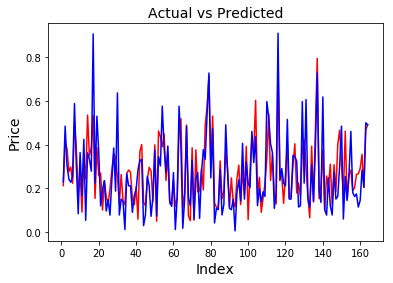

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs Predicted
c = [i for i in range(1, 165, 1)]
fig = plt.figure()
plt.plot(c, y_pred, color="red")
plt.plot(c, y_test, color="blue")
plt.title("Actual vs Predicted", fontsize=14)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Price", fontsize=14)

Text(0, 0.5, 'y_pred_m6')

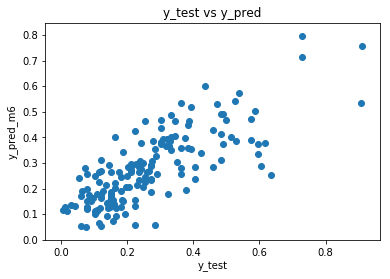

In [34]:
# Scatter plot for actual and predicted values
fig = plt.figure()
plt.scatter(y_test, y_pred)
plt.title("y_test vs y_pred")
plt.xlabel("y_test")
plt.ylabel("y_pred_m6")


Text(0, 0.5, 'y_test-y_pred ')

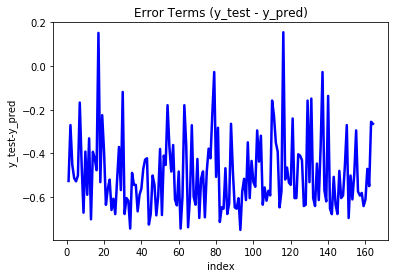

In [35]:
# Plotting Error terms
fig = plt.figure()
c = [i for i in range(1,165,1)]
plt.plot(c, y_test-y_pred[1], color="blue", linewidth=2.5, linestyle="-")
plt.title("Error Terms (y_test - y_pred)")
plt.xlabel("index")
plt.ylabel("y_test-y_pred ")


Text(0, 0.5, 'Index')

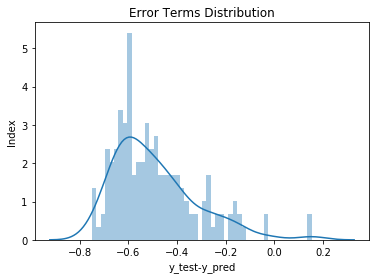

In [36]:
import seaborn as sns
# Plotting Error terms to understand distribution
fig = plt.figure()
sns.distplot(( y_test-y_pred[1]), bins=50)
plt.title("Error Terms Distribution")
plt.xlabel("y_test-y_pred")
plt.ylabel("Index")

In [37]:
import numpy as np
# Calculate Root Mean Squared Error
from sklearn import metrics
print("RMSE::", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE:: 0.10820352538131708
